In [3]:
import pandas as pd

# 1️⃣ 기존 데이터 불러오기
df = pd.read_csv("p24_final_labeled_with_features.csv", encoding='utf-8-sig')

# 2️⃣ 성별별 AI기기 보유율 매핑
gender_map = {0: 15.3, 1: 7.0}
df['AI기기보유율_성별'] = df['성별'].map(gender_map)

# 3️⃣ 연령별 AI기기 보유율 매핑 (연령코드 기준 매핑)
# (참고: 연령코드 예시 : 1=10세미만, 2=10대, 3=20대, 4=30대, 5=40대, 6=50대, 7=60대, 8=70세 이상)
age_map = {
    1: None,   # 10세 미만 제외
    2: 12.9,   # 20대 이하 → 10대와 합산
    3: 12.9,   # 20대 이하
    4: 17.9,   # 30대
    5: 20.0,   # 40대
    6: 15.8,   # 50대
    7: 11.4,   # 60대
    8: 3.0     # 70세 이상
}
df['AI기기보유율_연령'] = df['연령'].map(age_map)

# 4️⃣ 소득별 AI기기 보유율 매핑 (소득코드 그룹으로 맞춰주어야 함)
income_map = {
    0: 5.37,   # 저소득 그룹 (평균)
    1: 17.03,  # 중소득 그룹 (평균)
    2: 23.1    # 고소득 그룹
}
df['AI기기보유율_소득'] = df['소득그룹'].map(income_map)

# 기존 학력코드 → 공공데이터 그룹으로 매핑
def map_edu(x):
    if x <= 4:
        return 1   # 고졸 이하
    elif x == 5:
        return 2   # 대졸 이상
    else:
        return 3   # 대학원생 이상

df['학력그룹'] = df['학력'].apply(map_edu)

edu_map = {
    1: 9.0,
    2: 19.7,
    3: 0
}
df['AI기기보유율_학력'] = df['학력그룹'].map(edu_map)


# 6️⃣ 결과 확인
print(df.head())

# 7️⃣ 파생변수 포함 최종 저장
df.to_csv("p24_final_labeled_with_ai_device.csv", index=False, encoding='utf-8-sig')


   성별  연령  학력  직업  소득  스마트폰보유  검색능력  정보판별1(사실확인)  정보판별2(근거확인)  정보판별3(상업적의도확인)  \
0   1   6   5   0   1       1     5            2            2               3   
1   1   3   5   1   5       1     5            2            2               3   
2   0   3   5   1   5       1     5            2            2               1   
3   0   6   5   1   5       1     5            2            2               2   
4   0   4   5   1   5       1     5            3            2               3   

   ...  소외이진라벨  Active_Score  Info_Literacy_Index  SNS_Intensity  고령여부  \
0  ...       1          23.0                   10           15.0     1   
1  ...       1          25.0                    8           17.0     0   
2  ...       0          21.0                    6           13.0     0   
3  ...       0          24.0                    8           16.0     1   
4  ...       0          23.0                    9           15.0     0   

   AI기기보유율_성별  AI기기보유율_연령  AI기기보유율_소득  학력그룹  AI기기보유율_학력  
0         

In [ ]:
#학력 그룹 한 번 더 생각해보기

In [10]:
import matplotlib
import matplotlib.pyplot as plt

# 한글 폰트 설정 (윈도우 기준: 맑은고딕)
matplotlib.rc('font', family='Malgun Gothic')

# 마이너스 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

=== Random Forest (기본 파라미터, 공공데이터 포함) ===
              precision    recall  f1-score   support

           0       0.61      0.70      0.65       452
           1       0.69      0.60      0.64       504

    accuracy                           0.65       956
   macro avg       0.65      0.65      0.65       956
weighted avg       0.65      0.65      0.65       956



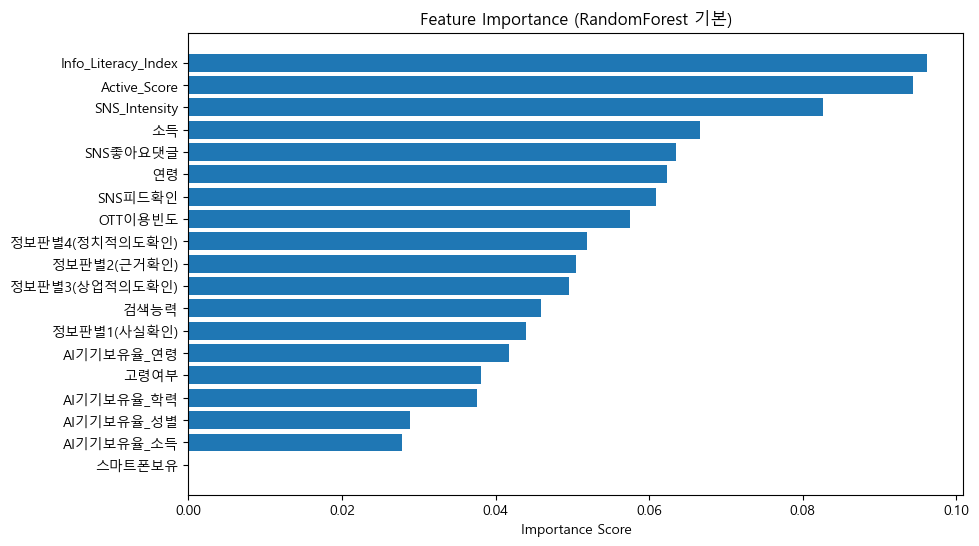

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv("p24_final_labeled_with_ai_device.csv", encoding='utf-8-sig')
df = df.dropna(subset=['소외이진라벨'])

# 2️⃣ X, y 설정 (소득그룹 제외, 소득 원본코드 사용)
X = df[[
    '검색능력', '정보판별1(사실확인)', '정보판별2(근거확인)',
    '정보판별3(상업적의도확인)', '정보판별4(정치적의도확인)',
    'SNS피드확인', 'SNS좋아요댓글', 'OTT이용빈도',
    '스마트폰보유', '소득', '연령',
    'Active_Score', 'Info_Literacy_Index', 'SNS_Intensity', '고령여부',
    'AI기기보유율_성별', 'AI기기보유율_연령', 'AI기기보유율_소득', 'AI기기보유율_학력'
]]
y = df['소외이진라벨']

# 3️⃣ Train-Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4️⃣ SMOTE 적용 (결측 제거 후 진행)
X_train_no_na = X_train.dropna()
y_train_no_na = y_train.loc[X_train_no_na.index]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_no_na, y_train_no_na)

# 5️⃣ 테스트셋 결측 제거
X_test_no_na = X_test.dropna()
y_test_no_na = y_test.loc[X_test_no_na.index]

# 6️⃣ RandomForest (튜닝 없이 기본 파라미터 적용)
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test_no_na)

# 7️⃣ 성능평가 출력
print("=== Random Forest (기본 파라미터, 공공데이터 포함) ===")
print(classification_report(y_test_no_na, y_pred_rf))

# 8️⃣ 변수 중요도 시각화
importances = rf_model.feature_importances_
features = X.columns

# 중요도 내림차순 정렬
sorted_idx = importances.argsort()[::-1]
plt.figure(figsize=(10,6))
plt.barh(range(len(features)), importances[sorted_idx])
plt.yticks(range(len(features)), features[sorted_idx])
plt.xlabel("Importance Score")
plt.title("Feature Importance (RandomForest 기본)")
plt.gca().invert_yaxis()
plt.show()


=== 튜닝 후 RandomForest 성능 ===
              precision    recall  f1-score   support

           0       0.60      0.67      0.64       452
           1       0.67      0.61      0.64       504

    accuracy                           0.64       956
   macro avg       0.64      0.64      0.64       956
weighted avg       0.64      0.64      0.64       956



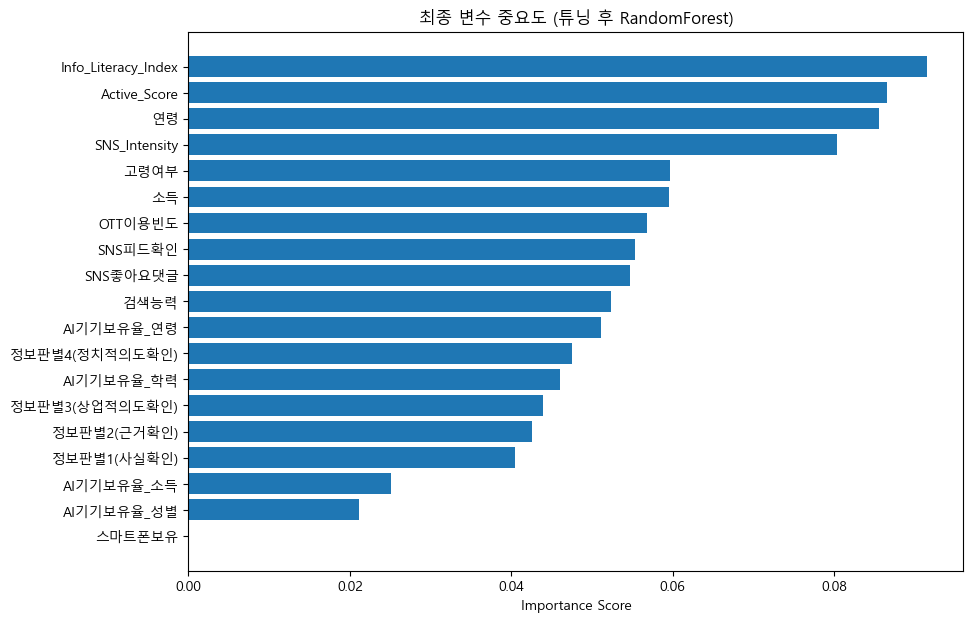

                Feature  Importance
12  Info_Literacy_Index    0.091451
11         Active_Score    0.086546
10                   연령    0.085539
13        SNS_Intensity    0.080308
14                 고령여부    0.059621
9                    소득    0.059572
7               OTT이용빈도    0.056808
5               SNS피드확인    0.055375
6              SNS좋아요댓글    0.054675
0                  검색능력    0.052337
16           AI기기보유율_연령    0.051054
4        정보판별4(정치적의도확인)    0.047464
18           AI기기보유율_학력    0.046068
3        정보판별3(상업적의도확인)    0.043868
2           정보판별2(근거확인)    0.042587
1           정보판별1(사실확인)    0.040409
17           AI기기보유율_소득    0.025113
15           AI기기보유율_성별    0.021187
8                스마트폰보유    0.000019


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv("p24_final_labeled_with_ai_device.csv", encoding='utf-8-sig')
df = df.dropna(subset=['소외이진라벨'])

# 2️⃣ X, y 설정
X = df[[
    '검색능력', '정보판별1(사실확인)', '정보판별2(근거확인)',
    '정보판별3(상업적의도확인)', '정보판별4(정치적의도확인)',
    'SNS피드확인', 'SNS좋아요댓글', 'OTT이용빈도',
    '스마트폰보유', '소득', '연령',
    'Active_Score', 'Info_Literacy_Index', 'SNS_Intensity', '고령여부',
    'AI기기보유율_성별', 'AI기기보유율_연령', 'AI기기보유율_소득', 'AI기기보유율_학력'
]]
y = df['소외이진라벨']

# 3️⃣ Train-Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4️⃣ SMOTE 적용 (결측 제거 후 진행)
X_train_no_na = X_train.dropna()
y_train_no_na = y_train.loc[X_train_no_na.index]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_no_na, y_train_no_na)

# 5️⃣ 하이퍼파라미터 튜닝 (Grid Search)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

# 6️⃣ 최적 모델 성능평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test.dropna())
print("=== 튜닝 후 RandomForest 성능 ===")
print(classification_report(y_test.loc[X_test.dropna().index], y_pred))

# 7️⃣ 최종 변수 중요도 시각화
importances = best_model.feature_importances_
features = X.columns

# 중요도 내림차순 정렬
sorted_idx = importances.argsort()[::-1]
plt.figure(figsize=(10,7))
plt.barh(range(len(features)), importances[sorted_idx])
plt.yticks(range(len(features)), features[sorted_idx])
plt.xlabel("Importance Score")
plt.title("최종 변수 중요도 (튜닝 후 RandomForest)")
plt.gca().invert_yaxis()
plt.show()

# 변수 중요도 수치 확인
importances = best_model.feature_importances_
features = X.columns

# 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# 중요도 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)


=== 튜닝 후 RandomForest 성능 ===
              precision    recall  f1-score   support

           0       0.61      0.70      0.65       452
           1       0.69      0.60      0.64       504

    accuracy                           0.65       956
   macro avg       0.65      0.65      0.65       956
weighted avg       0.65      0.65      0.65       956



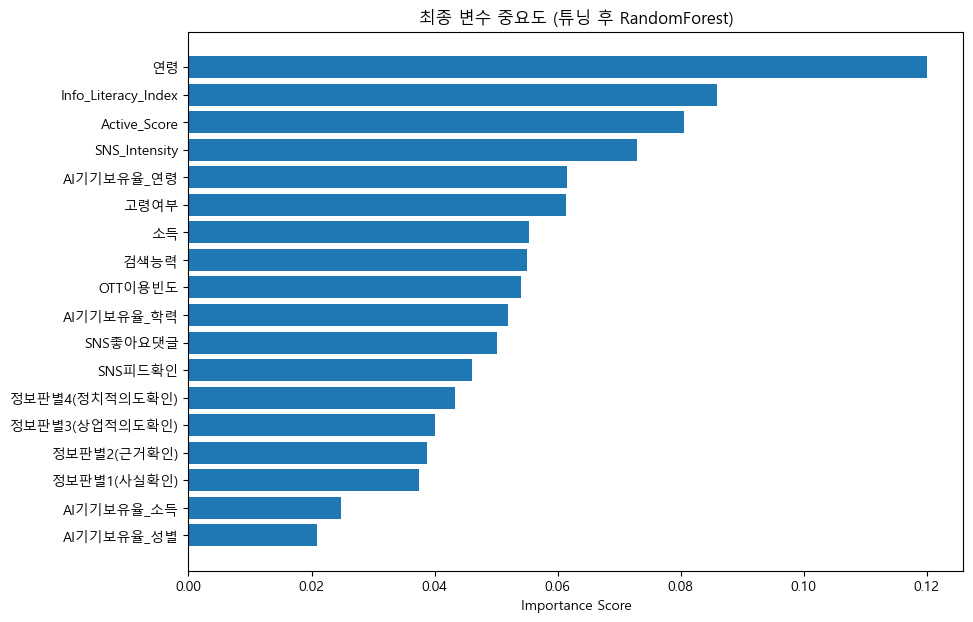

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv("p24_final_labeled_with_ai_device.csv", encoding='utf-8-sig')
df = df.dropna(subset=['소외이진라벨'])

# 2️⃣ X, y 설정
X = df[[
    '검색능력', '정보판별1(사실확인)', '정보판별2(근거확인)',
    '정보판별3(상업적의도확인)', '정보판별4(정치적의도확인)',
    'SNS피드확인', 'SNS좋아요댓글', 'OTT이용빈도',
     '소득', '연령',
    'Active_Score', 'Info_Literacy_Index', 'SNS_Intensity', '고령여부',
    'AI기기보유율_성별', 'AI기기보유율_연령', 'AI기기보유율_소득', 'AI기기보유율_학력'
]]
y = df['소외이진라벨']

# 3️⃣ Train-Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4️⃣ SMOTE 적용 (결측 제거 후 진행)
X_train_no_na = X_train.dropna()
y_train_no_na = y_train.loc[X_train_no_na.index]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_no_na, y_train_no_na)

# 5️⃣ 하이퍼파라미터 튜닝 (Grid Search)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

# 6️⃣ 최적 모델 성능평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test.dropna())
print("=== 튜닝 후 RandomForest 성능 ===")
print(classification_report(y_test.loc[X_test.dropna().index], y_pred))

# 7️⃣ 최종 변수 중요도 시각화
importances = best_model.feature_importances_
features = X.columns

# 중요도 내림차순 정렬
sorted_idx = importances.argsort()[::-1]
plt.figure(figsize=(10,7))
plt.barh(range(len(features)), importances[sorted_idx])
plt.yticks(range(len(features)), features[sorted_idx])
plt.xlabel("Importance Score")
plt.title("최종 변수 중요도 (튜닝 후 RandomForest)")
plt.gca().invert_yaxis()
plt.show()


In [15]:
# 변수 중요도 수치 확인
importances = best_model.feature_importances_
features = X.columns

# 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# 중요도 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)


                Feature  Importance
9                    연령    0.119977
11  Info_Literacy_Index    0.085894
10         Active_Score    0.080474
12        SNS_Intensity    0.072864
15           AI기기보유율_연령    0.061525
13                 고령여부    0.061339
8                    소득    0.055344
0                  검색능력    0.054992
7               OTT이용빈도    0.054114
17           AI기기보유율_학력    0.051953
6              SNS좋아요댓글    0.050074
5               SNS피드확인    0.046106
4        정보판별4(정치적의도확인)    0.043347
3        정보판별3(상업적의도확인)    0.040073
2           정보판별2(근거확인)    0.038697
1           정보판별1(사실확인)    0.037546
16           AI기기보유율_소득    0.024836
14           AI기기보유율_성별    0.020845


=== 튜닝 후 RandomForest 성능 ===
              precision    recall  f1-score   support

           0       0.61      0.69      0.64       452
           1       0.68      0.60      0.64       504

    accuracy                           0.64       956
   macro avg       0.64      0.64      0.64       956
weighted avg       0.65      0.64      0.64       956



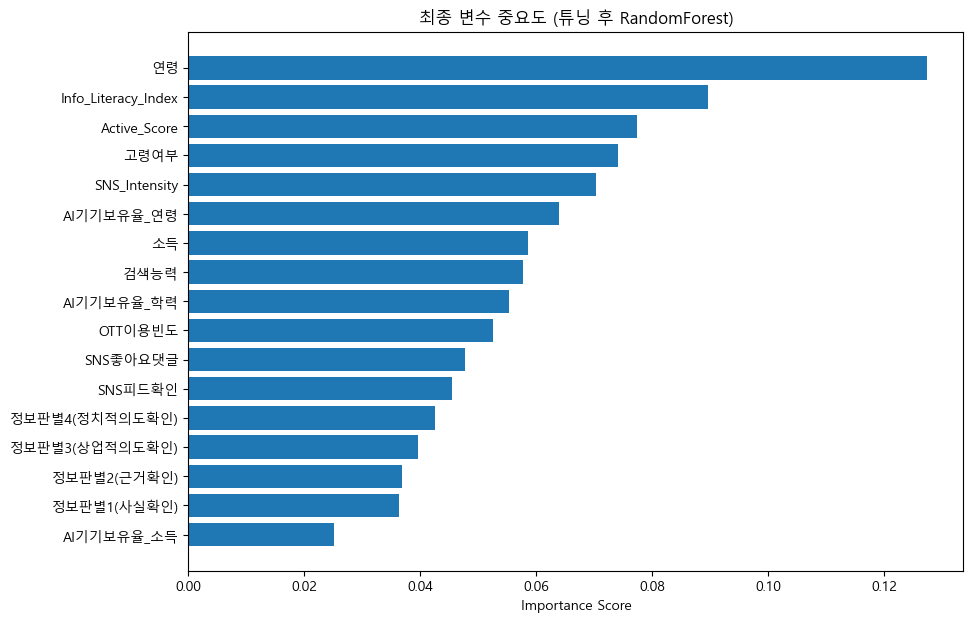

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
df = pd.read_csv("p24_final_labeled_with_ai_device.csv", encoding='utf-8-sig')
df = df.dropna(subset=['소외이진라벨'])

# 2️⃣ X, y 설정
X = df[[
    '검색능력', '정보판별1(사실확인)', '정보판별2(근거확인)',
    '정보판별3(상업적의도확인)', '정보판별4(정치적의도확인)',
    'SNS피드확인', 'SNS좋아요댓글', 'OTT이용빈도',
     '소득', '연령',
    'Active_Score', 'Info_Literacy_Index', 'SNS_Intensity', '고령여부',
     'AI기기보유율_연령', 'AI기기보유율_소득', 'AI기기보유율_학력'
]]
y = df['소외이진라벨']

# 3️⃣ Train-Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4️⃣ SMOTE 적용 (결측 제거 후 진행)
X_train_no_na = X_train.dropna()
y_train_no_na = y_train.loc[X_train_no_na.index]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_no_na, y_train_no_na)

# 5️⃣ 하이퍼파라미터 튜닝 (Grid Search)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

# 6️⃣ 최적 모델 성능평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test.dropna())
print("=== 튜닝 후 RandomForest 성능 ===")
print(classification_report(y_test.loc[X_test.dropna().index], y_pred))

# 7️⃣ 최종 변수 중요도 시각화
importances = best_model.feature_importances_
features = X.columns

# 중요도 내림차순 정렬
sorted_idx = importances.argsort()[::-1]
plt.figure(figsize=(10,7))
plt.barh(range(len(features)), importances[sorted_idx])
plt.yticks(range(len(features)), features[sorted_idx])
plt.xlabel("Importance Score")
plt.title("최종 변수 중요도 (튜닝 후 RandomForest)")
plt.gca().invert_yaxis()
plt.show()

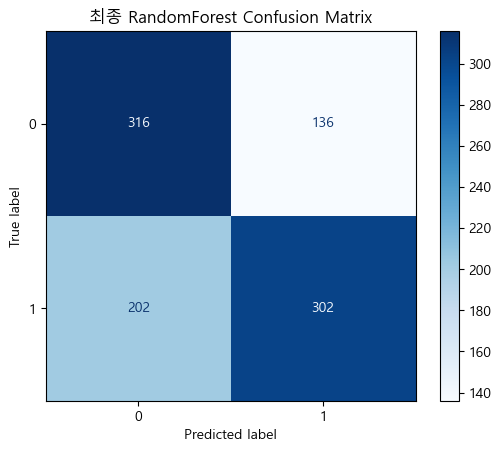

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_no_na, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("최종 RandomForest Confusion Matrix")
plt.show()


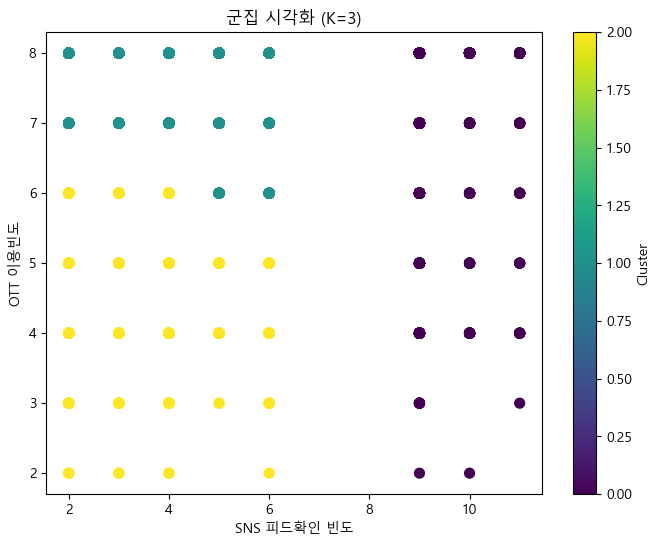

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 군집할 행동변수 선택
X_cluster = df[['SNS피드확인', 'OTT이용빈도']].dropna()

# KMeans 군집
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(X_cluster['SNS피드확인'], X_cluster['OTT이용빈도'], c=clusters, cmap='viridis', s=50)
plt.xlabel("SNS 피드확인 빈도")
plt.ylabel("OTT 이용빈도")
plt.title("군집 시각화 (K=3)")
plt.colorbar(label="Cluster")
plt.show()


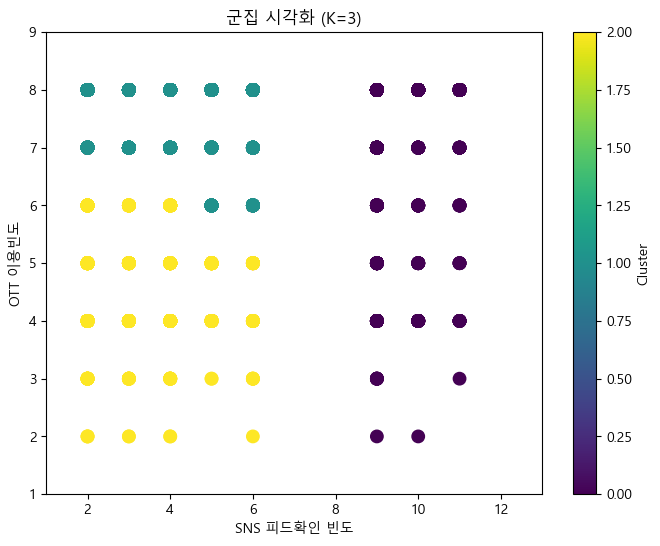

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(X_cluster['SNS피드확인'], X_cluster['OTT이용빈도'], c=clusters, cmap='viridis', s=80)
plt.xlabel("SNS 피드확인 빈도")
plt.ylabel("OTT 이용빈도")
plt.title("군집 시각화 (K=3)")

# 축 범위 살짝 padding
plt.xlim(1, 13)
plt.ylim(1, 9)
plt.colorbar(label="Cluster")
plt.show()


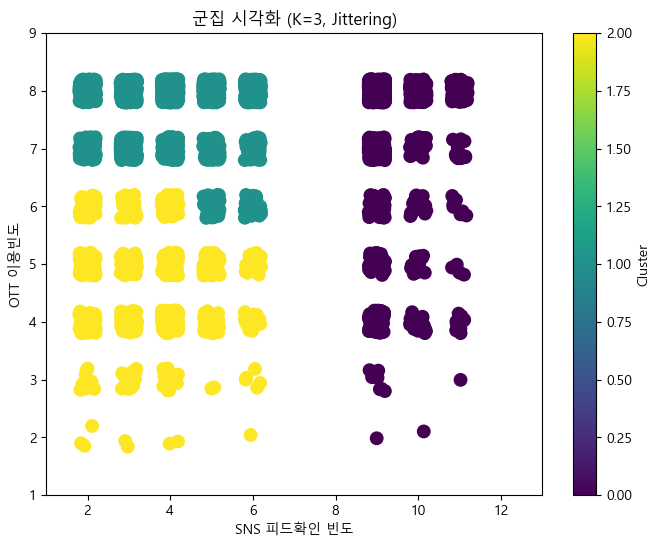

In [21]:
import numpy as np

plt.figure(figsize=(8,6))

# Jittering 적용
x_jitter = X_cluster['SNS피드확인'] + np.random.uniform(-0.2, 0.2, size=len(X_cluster))
y_jitter = X_cluster['OTT이용빈도'] + np.random.uniform(-0.2, 0.2, size=len(X_cluster))

plt.scatter(x_jitter, y_jitter, c=clusters, cmap='viridis', s=80)
plt.xlabel("SNS 피드확인 빈도")
plt.ylabel("OTT 이용빈도")
plt.title("군집 시각화 (K=3, Jittering)")
plt.xlim(1, 13)
plt.ylim(1, 9)
plt.colorbar(label="Cluster")
plt.show()


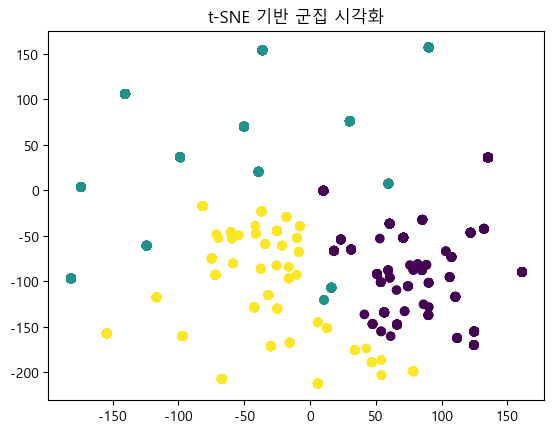

In [23]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_cluster)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap='viridis')
plt.title("t-SNE 기반 군집 시각화")
plt.show()
